In [2]:
! pip install -q librosa soundfile

In [3]:
from scipy.signal import butter, filtfilt

def apply_low_pass_filter(audio, sample_rate, cutoff_frequency=8000, order=5):
    """
    Applies a low-pass Butterworth filter to smooth the audio signal.

    Parameters:
        audio (ndarray): The input audio signal to smooth.
        sample_rate (int): The sampling rate of the audio.
        cutoff_frequency (float): The cutoff frequency for the low-pass filter in Hz.
        order (int): The order of the filter; higher orders yield a sharper cutoff.

    Returns:
        ndarray: The smoothed audio signal.
    """
    # Normalize the cutoff frequency
    nyquist = 0.5 * sample_rate
    normalized_cutoff = cutoff_frequency / nyquist

    # Design the low-pass filter
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)

    # Apply the filter to the audio signal
    smoothed_audio = filtfilt(b, a, audio)

    return smoothed_audio


In [5]:
import tensorflow as tf
import librosa
import numpy as np
import soundfile as sf
import os
import matplotlib.pyplot as plt


# Define the paths for content and style audio directly in the code
# content_audio_path = "/content/neuralsongstyle/audio/dont.mp3"
# style_audio_path = "/content/neuralsongstyle/audio/f48a9cdb-0573-417a-9cb9-281cd0f4da3e.mp3"
# output_audio_path = "/content/neuralsongstyle/audio/outdont2.wav"

content_audio_path = "../audio/fade.mp3"
style_audio_path = "../audio/dont.mp3"
output_audio_path = "../audio/outdont2.wav"

In [7]:
# Constants
N_FFT = 1024
N_FILTERS = 4096
ALPHA = 1e-2/2
BETA = 5
learning_rate = 1e-1
iterations = 100

# Reads wav file and produces spectrum (Fourier phases are ignored)
def read_audio_spectrum(filename):
    x, fs = librosa.load(filename, sr=None)
    print("Sampling rate:", fs)
    S = librosa.stft(x, n_fft=N_FFT)
    print("Shape of S:", S.shape)
    p = np.angle(S)
    integer = int(S.shape[1]*3/4)
    S = np.log1p(np.abs(S[:, : integer]))  # Log amplitude spectrum
    return S, fs

# Load content and style audio
a_content, fs = read_audio_spectrum(content_audio_path)
a_style, fs = read_audio_spectrum(style_audio_path)

# Setup audio shapes and kernel
N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]
a_content_tf = np.ascontiguousarray(a_content.T[None, None, :, :])
a_style_tf = np.ascontiguousarray(a_style.T[None, None, :, :])

# Filter shape "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))


# Update kernel definitions to match input channels for each layer
kernel1 = np.random.randn(1, 5, N_CHANNELS, N_FILTERS).astype(np.float32) * std
kernel2 = np.random.randn(1, 5, N_FILTERS, N_FILTERS).astype(np.float32) * std

def build_model(x):
    # First convolutional layer with kernel1
    kernel1_tf = tf.constant(kernel1)
    conv1 = tf.nn.conv2d(x, kernel1_tf, strides=[1, 1, 1, 1], padding="VALID")
    relu1 = tf.nn.relu(conv1)

    # Second convolutional layer with kernel2
    kernel2_tf = tf.constant(kernel2)
    conv2 = tf.nn.conv2d(relu1, kernel2_tf, strides=[1, 1, 1, 1], padding="VALID")
    relu2 = tf.nn.relu(conv2)

    return relu2


# Define content and style features
x_content = tf.convert_to_tensor(a_content_tf, dtype=tf.float32)
x_style = tf.convert_to_tensor(a_style_tf, dtype=tf.float32)
net_content = build_model(x_content)
net_style = build_model(x_style)

# Calculate content and style features
content_features = net_content
features = tf.reshape(net_style, (-1, N_FILTERS))
style_gram = tf.matmul(tf.transpose(features), features) / N_SAMPLES

# Optimizing the content and style features
x_gen = tf.Variable(tf.random.normal([1, 1, N_SAMPLES, N_CHANNELS]) * 1e-3, dtype=tf.float32)


# Build model with generated input
net_gen = build_model(x_gen)
content_loss = ALPHA * 2 * tf.nn.l2_loss(net_gen - content_features)

# Style loss using Gram matrix
feats = tf.reshape(net_gen, (-1, N_FILTERS))
gram = tf.matmul(tf.transpose(feats), feats) / N_SAMPLES
style_loss = BETA * 2 * tf.nn.l2_loss(gram - style_gram)

# Total loss
loss = content_loss + style_loss

# Optimizer
opt = tf.optimizers.Adam(learning_rate=learning_rate)

# Training function
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        net_gen = build_model(x_gen)
        content_loss = ALPHA * 2 * tf.nn.l2_loss(net_gen - content_features)
        feats = tf.reshape(net_gen, (-1, N_FILTERS))
        gram = tf.matmul(tf.transpose(feats), feats) / N_SAMPLES
        style_loss = BETA * 2 * tf.nn.l2_loss(gram - style_gram)
        loss = content_loss + style_loss
    gradients = tape.gradient(loss, [x_gen])
    opt.apply_gradients(zip(gradients, [x_gen]))
    return loss

# Training loop
for i in range(iterations):
    loss_value = train_step()
    if (i + 1) % 10 == 0:
      print(f"Iteration {i + 1}, Loss: {loss_value.numpy()}")

# Extracting and converting the optimized result back to audio
result = x_gen.numpy()
a = np.zeros_like(a_content)
a[:N_CHANNELS, :] = np.expm1(result[0, 0].T)

# Phase reconstruction using Griffin-Lim
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for _ in range(1000):
    S = a * np.exp(1j * p)
    x_rec = librosa.istft(S)
    p = np.angle(librosa.stft(x_rec, n_fft=N_FFT))

x_rec_smoothed = apply_low_pass_filter(x_rec, fs, cutoff_frequency=8000, order=5)
# Saving the output
sf.write(output_audio_path, x_rec_smoothed, fs)
print(f"Output audio saved to {output_audio_path}")


Sampling rate: 44100
Shape of S: (513, 1733)
Sampling rate: 44100
Shape of S: (513, 1747)
Iteration 10, Loss: 1944.074462890625
Iteration 20, Loss: 795.5914306640625
Iteration 30, Loss: 469.55023193359375
Iteration 40, Loss: 358.8583984375
Iteration 50, Loss: 288.7079772949219
Iteration 60, Loss: 238.09225463867188
Iteration 70, Loss: 202.0599822998047
Iteration 80, Loss: 176.94886779785156
Iteration 90, Loss: 159.02259826660156
Iteration 100, Loss: 145.9490509033203
Output audio saved to ../audio/outdont2.wav


Sampling rate: 44100
Shape of S: (513, 1733)
Sampling rate: 44100
Shape of S: (513, 1747)
Sampling rate: 44100
Shape of S: (513, 1299)


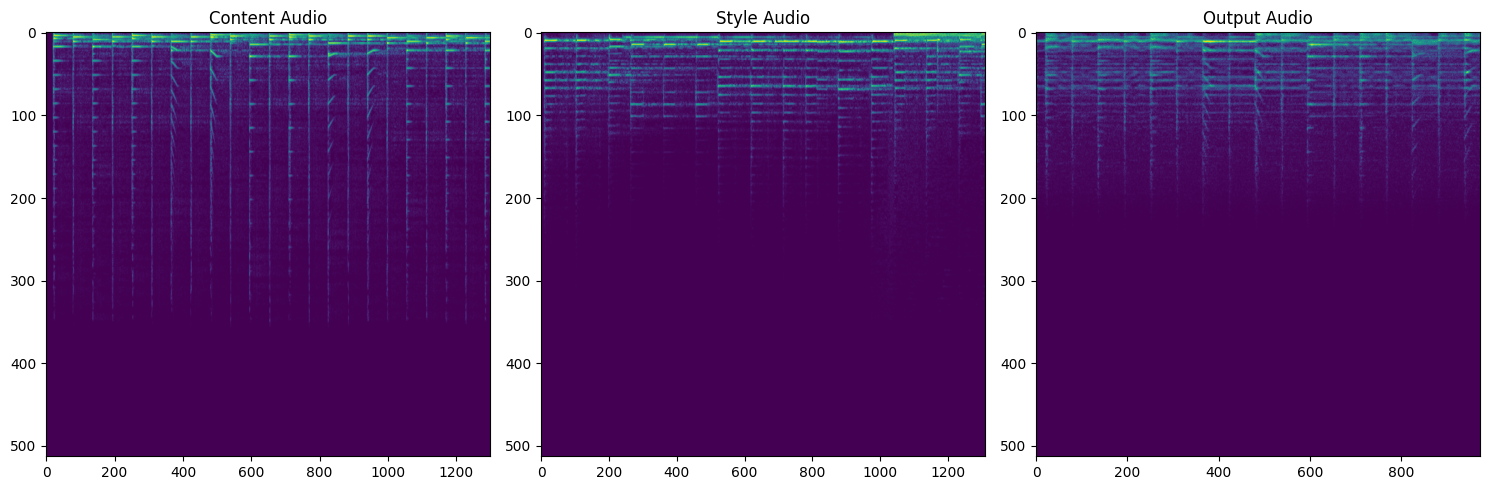

None


In [9]:
# Optional: Plot spectrograms (in a separate cell)
def plot_spectrograms(content_audio_path, style_audio_path, output_audio_path):
    # Read and process audio files
    # Load and compute spectrograms
    content_spec, _ = read_audio_spectrum(content_audio_path)
    style_spec, _ = read_audio_spectrum(style_audio_path)
    output_spec, _ = read_audio_spectrum(output_audio_path)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot spectrograms
    ax1.imshow(content_spec, aspect='auto')
    ax1.set_title('Content Audio')
    
    ax2.imshow(style_spec, aspect='auto')
    ax2.set_title('Style Audio')
    
    ax3.imshow(output_spec, aspect='auto')
    ax3.set_title('Output Audio')
    
    plt.tight_layout()
    print(plt.show())

plot_spectrograms(content_audio_path, style_audio_path, output_audio_path) 

## Attempt 2: build_model network


In [ ]:
# import tensorflow as tf
# import librosa
# import numpy as np
# import soundfile as sf
# import os



# # Define the paths for content and style audio directly in the code
# content_audio_path = "/content/neuralsongstyle/audio/dont.mp3"
# style_audio_path = "/content/neuralsongstyle/audio/fade.mp3"
# output_audio_path = "/content/neuralsongstyle/audio/outdont2.wav"

# # Constants
# N_FFT = 1024
# N_FILTERS = 4096
# ALPHA = 1e-2
# BETA = 5
# learning_rate = 1e-1
# iterations = 500

# # Reads wav file and produces spectrum (Fourier phases are ignored)
# def read_audio_spectrum(filename):
#     x, fs = librosa.load(filename, sr=None)
#     print("Sampling rate:", fs)
#     S = librosa.stft(x, n_fft=N_FFT)
#     print("Shape of S:", S.shape)
#     p = np.angle(S)
#     S = np.log1p(np.abs(S[:, :1000]))  # Log amplitude spectrum
#     return S, fs

# # Load content and style audio
# a_content, fs = read_audio_spectrum(content_audio_path)
# a_style, fs = read_audio_spectrum(style_audio_path)

# # Setup audio shapes and kernel
# N_SAMPLES = a_content.shape[1]
# N_CHANNELS = a_content.shape[0]
# a_style = a_style[:N_CHANNELS, :N_SAMPLES]
# a_content_tf = np.ascontiguousarray(a_content.T[None, None, :, :])
# a_style_tf = np.ascontiguousarray(a_style.T[None, None, :, :])

# # Filter shape "[filter_height, filter_width, in_channels, out_channels]"
# std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
# # # Update kernel definitions to match input channels for each layer
# kernel = np.random.randn(1, 5, N_CHANNELS, N_FILTERS).astype(np.float32) * std

# # Placeholder for dense weights and output weights
# dense_weights = None
# output_weights = None
# num_classes = N_FILTERS

# def build_model(x):
#     global dense_weights, output_weights
#     # First convolutional layer
#     kernel1_tf = tf.constant(np.random.randn(1, 5, x.shape[-1], 64).astype(np.float32) * std)
#     conv1 = tf.nn.conv2d(x, kernel1_tf, strides=[1, 1, 1, 1], padding="VALID")
#     relu1 = tf.nn.relu(conv1)

#     # Adjust kernel2 based on conv1's output shape
#     kernel2_tf = tf.constant(np.random.randn(1, 5, relu1.shape[-1], 128).astype(np.float32) * std)
#     conv2 = tf.nn.conv2d(relu1, kernel2_tf, strides=[1, 1, 1, 1], padding="VALID")
#     relu2 = tf.nn.relu(conv2)

#     # Flatten layer
#     flatten = tf.reshape(relu2, [tf.shape(relu2)[0], -1])

#     # Initialize weights only if they are None
#     if dense_weights is None:
#         dense_weights = tf.Variable(tf.random.normal([flatten.shape[-1], 256]), dtype=tf.float32)
#     if output_weights is None:
#         output_weights = tf.Variable(tf.random.normal([256, num_classes]), dtype=tf.float32)

#     # Fully connected and output layers
#     dense = tf.nn.relu(tf.matmul(flatten, dense_weights))
#     dropout = tf.nn.dropout(dense, rate=0.5)
#     logits = tf.matmul(dropout, output_weights)
#     softmax = tf.nn.softmax(logits)

#     return softmax



# # Define content and style features
# x_content = tf.convert_to_tensor(a_content_tf, dtype=tf.float32)
# x_style = tf.convert_to_tensor(a_style_tf, dtype=tf.float32)
# net_content = build_model(x_content)
# net_style = build_model(x_style)

# # Calculate content and style features
# content_features = net_content
# features = tf.reshape(net_style, (-1, N_FILTERS))
# style_gram = tf.matmul(tf.transpose(features), features) / N_SAMPLES

# # Optimizing the content and style features
# x_gen = tf.Variable(tf.random.normal([1, 1, N_SAMPLES, N_CHANNELS]) * 1e-3, dtype=tf.float32)


# # Build model with generated input
# net_gen = build_model(x_gen)
# content_loss = ALPHA * 2 * tf.nn.l2_loss(net_gen - content_features)

# # Style loss using Gram matrix
# feats = tf.reshape(net_gen, (-1, N_FILTERS))
# gram = tf.matmul(tf.transpose(feats), feats) / N_SAMPLES
# style_loss = BETA * 2 * tf.nn.l2_loss(gram - style_gram)

# # Total loss
# loss = content_loss + style_loss

# # Optimizer
# opt = tf.optimizers.Adam(learning_rate=learning_rate)

# # Training function
# @tf.function
# def train_step():
#     with tf.GradientTape() as tape:
#         net_gen = build_model(x_gen)
#         content_loss = ALPHA * 2 * tf.nn.l2_loss(net_gen - content_features)
#         feats = tf.reshape(net_gen, (-1, N_FILTERS))
#         gram = tf.matmul(tf.transpose(feats), feats) / N_SAMPLES
#         style_loss = BETA * 2 * tf.nn.l2_loss(gram - style_gram)
#         loss = content_loss + style_loss
#     gradients = tape.gradient(loss, [x_gen])
#     opt.apply_gradients(zip(gradients, [x_gen]))
#     return loss

# # Training loop
# for i in range(iterations):
#     loss_value = train_step()
#     if (i + 1) % 10 == 0:
#       print(f"Iteration {i + 1}, Loss: {loss_value.numpy()}")

# # Extracting and converting the optimized result back to audio
# result = x_gen.numpy()
# a = np.zeros_like(a_content)
# a[:N_CHANNELS, :] = np.expm1(result[0, 0].T)

# # Phase reconstruction using Griffin-Lim
# p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
# for _ in range(1000):
#     S = a * np.exp(1j * p)
#     x_rec = librosa.istft(S)
#     p = np.angle(librosa.stft(x_rec, n_fft=N_FFT))

# x_rec_smoothed = apply_low_pass_filter(x_rec, fs, cutoff_frequency=8000, order=5)
# # Saving the output
# sf.write(output_audio_path, x_rec_smoothed, fs)
# print(f"Output audio saved to {output_audio_path}")
